In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,SimpleRNN
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from matplotlib import pyplot
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [14]:
# Load dataset
file_path = "alldata_fi.csv"
df = pd.read_csv(file_path)

# Convert Date column to datetime and sort
df['Date'] = pd.to_datetime(df['Date'])

# Select relevant columns
columns_needed = ['Date', 'option_name', 'Closing_Price_(Option)', 'Exercise_Price',
                  'Spot_Price_of_Asset', 'riskfreerate', 'time_to_expiration']
df = df[columns_needed]

df = df.sort_values(by=['option_name', 'Date'])

#Calculate daily log returns for each option_name group
df['log_return'] = df.groupby('option_name')['Spot_Price_of_Asset'].transform(lambda x: np.log(x / x.shift(1)))

#Calculate 30-day rolling historical volatility (annualized with √240)
def compute_vol(group):
    group['volatility'] = group['log_return'].rolling(window=30).std() * np.sqrt(240)
    return group

df = df.groupby('option_name', group_keys=False).apply(compute_vol)

# Drop log_return
df.drop(columns=['log_return'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27842 entries, 11852 to 3236
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    27842 non-null  datetime64[ns]
 1   option_name             27842 non-null  object        
 2   Closing_Price_(Option)  27842 non-null  float64       
 3   Exercise_Price          27842 non-null  float64       
 4   Spot_Price_of_Asset     27842 non-null  float64       
 5   riskfreerate            27842 non-null  float64       
 6   time_to_expiration      27842 non-null  float64       
 7   volatility              18294 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 1.9+ MB


<ipython-input-14-4857a99448eb>:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('option_name', group_keys=False).apply(compute_vol)


In [15]:
df = df.dropna(subset=['volatility'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18294 entries, 2696 to 3236
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    18294 non-null  datetime64[ns]
 1   option_name             18294 non-null  object        
 2   Closing_Price_(Option)  18294 non-null  float64       
 3   Exercise_Price          18294 non-null  float64       
 4   Spot_Price_of_Asset     18294 non-null  float64       
 5   riskfreerate            18294 non-null  float64       
 6   time_to_expiration      18294 non-null  float64       
 7   volatility              18294 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 1.3+ MB


In [16]:

# Train-test split parameters
TRAIN_SIZE = 0.8

# Initialize empty DataFrames
train_df = pd.DataFrame()
test_df = pd.DataFrame()

# Perform train-test split for each option separately
option_names = df["option_name"].unique()

train_df = pd.DataFrame()
test_df = pd.DataFrame()

for option in option_names:
    section = df[df["option_name"] == option].sort_values(by="Date").copy()
    l = len(section)

    train_df = pd.concat([train_df, section.iloc[:int(l * TRAIN_SIZE), :]])
    test_df = pd.concat([test_df, section.iloc[int(l * TRAIN_SIZE):, :]])

# Reset indices
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)




In [17]:

train_df_numeric = train_df.drop(columns=['Date', 'option_name'])
test_df_numeric = test_df.drop(columns=['Date', 'option_name'])


# -------------------------
# Function for sequence generation
# -------------------------
def create_sequences(data: pd.DataFrame, seq_length: int, forecast_horizon: int = 1):
    """
    Create sequences for LSTM time series forecasting.

    Parameters:
    - data (pd.DataFrame): Input time series data with multiple features.
    - seq_length (int): Number of time steps in each input sequence.
    - forecast_horizon (int, optional): Number of steps ahead to predict. Default is 1.

    Returns:
    - X (np.ndarray): Input features of shape (num_samples, seq_length, num_features).
    - y (np.ndarray): Target values of shape (num_samples,).
    """
    if seq_length <= 0 or forecast_horizon <= 0:
        raise ValueError("`seq_length` and `forecast_horizon` must be positive integers.")

    num_samples = len(data) - seq_length - forecast_horizon + 1
    num_features = data.shape[1]

    if num_samples <= 0:
        raise ValueError("Not enough data to create sequences. Reduce `seq_length` or `forecast_horizon`.")

    # Preallocate NumPy arrays for efficiency
    X = np.zeros((num_samples, seq_length, num_features), dtype=np.float32)
    y = np.zeros((num_samples,), dtype=np.float32)

    for i in range(num_samples):
        X[i] = data.iloc[i : i + seq_length].values  # Extract input sequence
        y_idx = i + seq_length + forecast_horizon - 1

        if y_idx >= len(data):  # Prevent indexing errors
            break

        y[i] = data.iloc[y_idx]['Closing_Price_(Option)']  # Extract target value

    return X, y

# Apply function to create proper multivariate sequences
seq_length = 20  # Lookback window
forecast_horizon = 1  # Predict the next time step

X_train, y_train = create_sequences(train_df_numeric, seq_length, forecast_horizon)
X_test, y_test = create_sequences(test_df_numeric, seq_length, forecast_horizon)

# Validation split from training data
val_size = 0.05
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, shuffle=False)

# ✅ Use RobustScaler for feature scaling
scaler_features = StandardScaler()
X_train_scaled = scaler_features.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler_features.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = scaler_features.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# ✅ Use StandardScaler for target scaling
scaler_target = StandardScaler()
y_train_scaled = scaler_target.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_target.transform(y_val.reshape(-1, 1))  # No fitting!
y_test_scaled = scaler_target.transform(y_test.reshape(-1, 1))  # No fitting!

# ✅ Print dataset shapes for verification
print("✅ X_train_scaled shape:", X_train_scaled.shape)
print("✅ X_val_scaled shape:", X_val_scaled.shape)
print("✅ X_test_scaled shape:", X_test_scaled.shape)
print("✅ y_train_scaled shape:", y_train_scaled.shape)
print("✅ y_val_scaled shape:", y_val_scaled.shape)
print("✅ y_test_scaled shape:", y_test_scaled.shape)


✅ X_train_scaled shape: (13757, 20, 6)
✅ X_val_scaled shape: (725, 20, 6)
✅ X_test_scaled shape: (3772, 20, 6)
✅ y_train_scaled shape: (13757, 1)
✅ y_val_scaled shape: (725, 1)
✅ y_test_scaled shape: (3772, 1)


In [18]:
timesteps= X_train_scaled.shape[1]
features= X_train_scaled.shape[2]


# Define the stacked SimpleRNN model
def create_advanced_lstm_model():
    model = Sequential()

    # First SimpleRNN Layer
    model.add(SimpleRNN(units=224, return_sequences=True, input_shape=(timesteps, features)))
    model.add(Dropout(0.4))

    # Fully Connected Output Layer
    model.add(Dense(units=1))

    # Compile Model
    model.compile(optimizer=Adam(learning_rate=0.002623777393997694), loss="mean_squared_error")

    return model

# Create and compile the model
model = create_advanced_lstm_model()


# Early Stopping & Learning Rate Scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10,  verbose=1)

# Train the improved model
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100, batch_size=16,
    validation_data=(X_val_scaled, y_val_scaled),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


860/860 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.3355 - val_loss: 1.2208 - learning_rate: 0.0026
Epoch 2/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.2402 - val_loss: 1.3544 - learning_rate: 0.0026
Epoch 3/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.2345 - val_loss: 1.1363 - learning_rate: 0.0026
Epoch 4/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.2125 - val_loss: 1.2207 - learning_rate: 0.0026
Epoch 5/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.2336 - val_loss: 1.2043 - learning_rate: 0.0026
Epoch 6/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.2070 - val_loss: 1.1277 - learning_rate: 0.0026
Epoch 7/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.2258 - val_loss: 1.0868 - learning_rate: 0.0026
Epoch 8/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.2950 - val_loss: 1.2912 - learning_rate: 0.0026
Epoch 9/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.2757 - val_loss: 1.2723 - learning_rate: 0.0

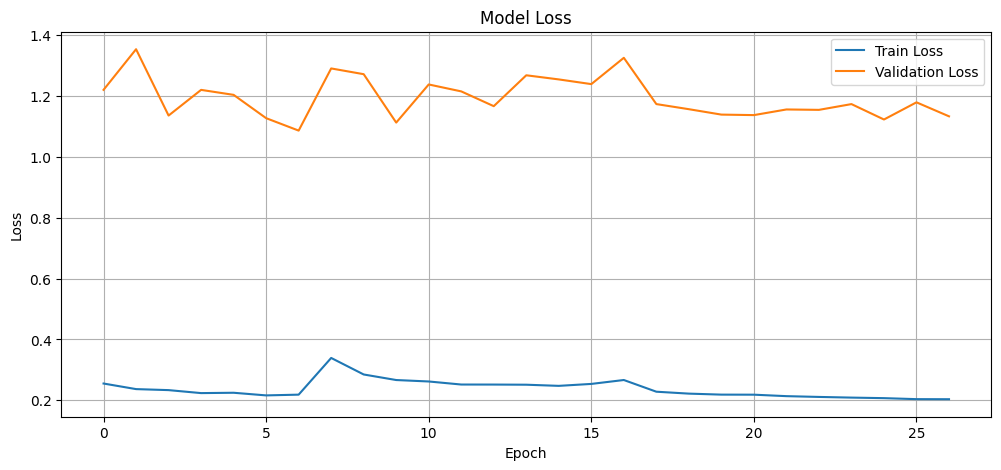

In [19]:

# history is the output of model.fit()
plt.figure(figsize=(12, 5))

# Loss (MSE) Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
pip install arabic-reshaper python-bidi


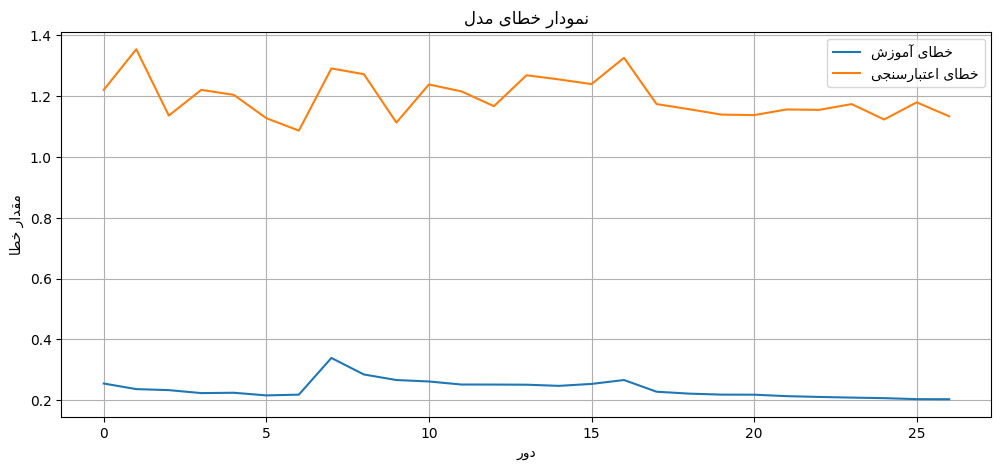

In [21]:
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

# Helper to render Farsi text correctly
def reshape_farsi(text):
    return get_display(arabic_reshaper.reshape(text))

# Plotting training/validation loss
plt.figure(figsize=(12, 5))

plt.plot(history.history['loss'], label=reshape_farsi('خطای آموزش'))
plt.plot(history.history['val_loss'], label=reshape_farsi('خطای اعتبارسنجی'))

plt.title(reshape_farsi('نمودار خطای مدل'))
plt.xlabel(reshape_farsi('دور'))
plt.ylabel(reshape_farsi('مقدار خطا'))
plt.legend()
plt.grid(True)
plt.show()


In [22]:
def evaluate_model(y_true_scaled, y_pred_scaled, scaler, dataset_type="TEST"):
    """
    Evaluates model performance using multiple metrics.

    Parameters:
    - y_true_scaled: Scaled actual values (numpy array)
    - y_pred_scaled: Scaled predicted values (numpy array)
    - scaler: MinMaxScaler used for inverse transformation
    - dataset_type: "TEST" or "TRAIN" (used for print labels)

    Returns:
    - Dictionary of evaluation metrics
    """

    # ✅ Ensure Correct Shape for Inverse Transformation
    y_pred_scaled = y_pred_scaled.reshape(-1, 1)
    y_true_scaled = y_true_scaled.reshape(-1, 1)

    # ✅ Convert Back to Original Scale
    y_pred_original = scaler.inverse_transform(y_pred_scaled)
    y_true_original = scaler.inverse_transform(y_true_scaled)

    # ✅ Compute Metrics
    mae = mean_absolute_error(y_true_original, y_pred_original)
    rmse = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
    r2 = r2_score(y_true_original, y_pred_original)

    # ✅ Print Evaluation Results
    print(f"\n✅ {dataset_type} Data Metrics:")
    print(f"    - MAE  : {mae:.4f}")
    print(f"    - RMSE : {rmse:.4f}")
    print(f"    - R²   : {r2:.4f}")

    return {
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2 }

# ✅ Get Predictions
y_pred_test = model.predict(X_test_scaled)
if len(y_pred_test.shape) == 3:  # Shape (samples, timesteps, 1)
    y_pred_test = y_pred_test[:, -1, 0]  # Take last timestep output
y_pred_test = y_pred_test.reshape(-1, 1)


test_metrics = evaluate_model(y_test_scaled, y_pred_test, scaler_target, "TEST")

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

✅ TEST Data Metrics:
    - MAE  : 296.0876
    - RMSE : 550.0516
    - R²   : 0.8066


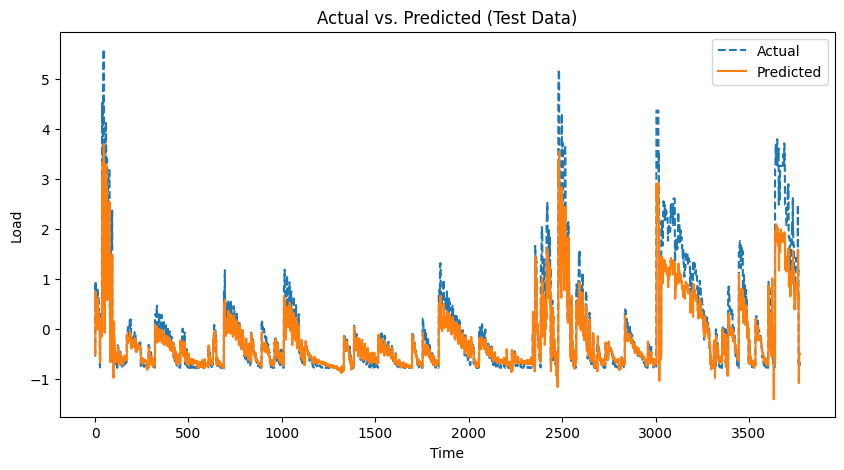

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_scaled, label="Actual", linestyle="dashed")
plt.plot(y_pred_test, label="Predicted")
plt.legend()
plt.title("Actual vs. Predicted (Test Data)")
plt.xlabel("Time")
plt.ylabel("Load")
plt.show()


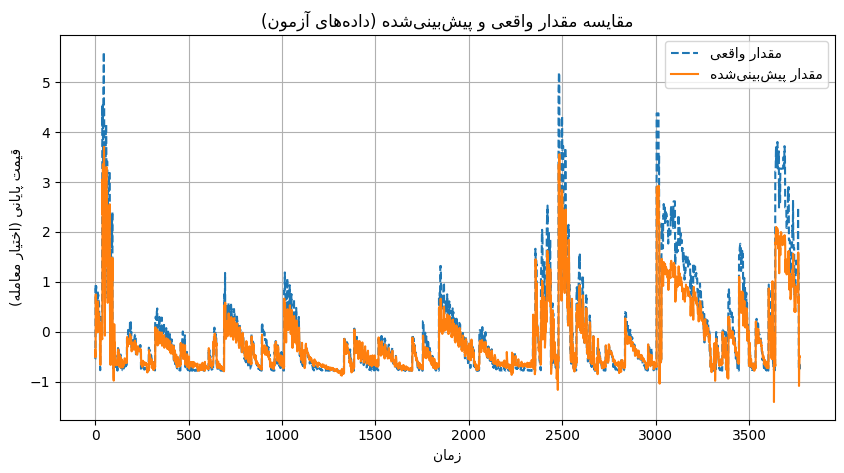

In [24]:
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

# Helper function
def reshape_farsi(text):
    return get_display(arabic_reshaper.reshape(text))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_test_scaled, label=reshape_farsi("مقدار واقعی"), linestyle="dashed")
plt.plot(y_pred_test, label=reshape_farsi("مقدار پیش‌بینی‌شده"))
plt.legend()
plt.title(reshape_farsi("مقایسه مقدار واقعی و پیش‌بینی‌شده (داده‌های آزمون)"))
plt.xlabel(reshape_farsi("زمان"))
plt.ylabel(reshape_farsi("قیمت پایانی (اختیار معامله)"))
plt.grid(True)
plt.show()
